In [1]:
import warnings
from collections import OrderedDict
import pandas as pd

import scipy
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.utils import resample
import pysindy as ps
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from scipy.integrate import odeint
from scipy.stats import multivariate_normal
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression


class My_STLSQ:
    def __init__(self, threshold=0.05, fit_intcpt = True):
        self.threshold = threshold
        self.fit_intcpt = fit_intcpt  
                

    def fit(self, True_X, y):
        """
        Perform least squares regression with LASSO regularization
        Parameters:
        -----------
        True_X : numpy array
            Feature matrix of shape (n_samples, n_features)
        y : numpy array
            Response vector of shape (n_samples,)
        self.threshold : float
            LASSO regularization parameter

        Returns:
        --------
        coef : numpy array
            Coefficient vector of the final model
        """

        if self.fit_intcpt:
            # Add a bias term to the input data
            X_ = np.insert(True_X, 0, 1, axis=1)
        else: X_ = np.copy(True_X)

        if len(y.shape) == 1:
            y = y.reshape(-1,1)
            
        n_features = X_.shape[1]
        self.Coeffs = []
        for i in range(y.shape[-1]):
#             print(i)
            X = np.copy(X_)
            y_i = y[:,i] #.reshape(-1)
#             print(y_i.shape)
            model = LinearRegression()
            coef = np.zeros(n_features)
            while True:
                model.fit(X, y_i)
                coef_new = model.coef_
                if np.max(np.abs(coef_new - coef)) < 1e-5:
                    break
                coef = coef_new
                small_coef = np.abs(coef) < self.threshold
                if np.sum(small_coef) == 0:
                    break
                X = X[:, ~small_coef]
                coef = coef[~small_coef]
            indx = find_indexes(X_[0],X[0])
            coefficient = np.zeros(n_features)
            coefficient[indx] = coef
            self.Coeffs.append(coefficient)
        return np.array(self.Coeffs)

    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Coeffs)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

    
    
class SequentialThresholdLeastSquares:
    def __init__(self, threshold=0.05, fit_intcpt = True):
        self.threshold = threshold*10
        self.fit_intcpt = fit_intcpt  
                
    
    def fit(self, X, y, ):        
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1) 
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
        
        self.Beta = [] #np.zeroes(y.shape[-1],X.shape[-1])
        for t in range(y.shape[-1]):
            yt = y[:,t]
            # Initialize the parameter vector
            self.beta = np.zeros(X.shape[1])

            # Compute the initial residual and RSS
            r = yt - np.dot(X, self.beta)
            RSS = np.sum(r**2)

            # Iterate until convergence
            while True:
                # Compute the correlation coefficients
                corr = np.abs(np.dot(X.T, r))

                # Find the feature with the highest correlation
                j_star = np.argmax(corr)

                # Check if the highest correlation is above the threshold
                if corr[j_star] > self.threshold:
                    # Compute the new parameter estimate for feature j_star
                    beta_j_star = np.dot(X[:,j_star], r) / np.dot(X[:,j_star], X[:,j_star])

                    # Update the parameter vector and residual
                    self.beta[j_star] += beta_j_star
                    r -= beta_j_star * X[:,j_star]
                    RSS = np.sum(r**2)
                else:
                    break
            self.Beta.append(self.beta)
        return np.array(self.Beta)
    
    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Beta)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

def LR(X, y, alpha, n_features):
    model = LinearRegression()
    coef = np.zeros(n_features)
    while True:
        model.fit(X, y)
        coef_new = model.coef_
        if np.max(np.abs(coef_new - coef)) < 1e-5:
            break
        coef = coef_new
        small_coef = np.abs(coef) < alpha
        if np.sum(small_coef) == 0:
            break
        X = X[:, ~small_coef]
        coef = coef[~small_coef]
    return X,coef


def find_indexes(array, elements):
    if type(array) != list:
        array = array.tolist()
        
    elements = np.array(elements)
    indexes = []
    for element in elements:
        try:
            index = array.index(element)
            indexes.append(index)
        except ValueError:
            indexes.append(None)
    return indexes

### Some Helper Functions

In [3]:
def plot_multivariate_normal(data, xlabel='x', ylabel='y', title='Multivariate Normal Distribution'):
    # Compute the mean and covariance of the data
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)

    # Create a grid of points for the x and y axes
    x, y = np.mgrid[mean[0]-3*np.sqrt(cov[0,0]):mean[0]+3*np.sqrt(cov[0,0]):100j,
                    mean[1]-3*np.sqrt(cov[1,1]):mean[1]+3*np.sqrt(cov[1,1]):100j]

    # Create a multivariate normal distribution using the mean and covariance
    mvn = multivariate_normal(mean=mean, cov=cov)

    # Evaluate the PDF of the multivariate normal distribution at each point on the grid
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    pdf = mvn.pdf(pos)
    
    # Set the plot title and axis labels
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot the multivariate normal distribution as a contour plot
    ax.contourf(x, y, pdf)
    # Show the plot
    plt.show()

def SINDY(noisy_data,t, threshold = 0.03, wl = 15, condit = False):
    """Fits SINDy model to a data and returns the resulting coefficients"""
    Poly_lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=True)
    optimizer = ps.STLSQ(threshold)#threshold = 0.3)
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(noisy_data,t)
    L_dl = np.vstack((noisy_data,dldt)).T

    model = ps.SINDy(
        differentiation_method=smoothed_fd,
        feature_library=Poly_lib,
        optimizer=optimizer,
        feature_names=["L", "dL"] 
    )
    if condit: 
        model.fit(L_dl, t)
        model.print()
        model.get_feature_names()
        return model.coefficients()#.reshape(-1)
    
    else:
        model.fit(L_dl, t)
        return L_dl, model
        

def sort_matrix(matrix, col_idx = -1):
    """Sorts a matrix by a predifine column in ascending order"""
    if len(matrix.shape)  == 1:
        matrix= matrix.reshape(-1,1)
    # Sort the matrix by the specified column
    sorted_matrix = sorted(matrix, key=lambda x: x[col_idx])
    return np.array(sorted_matrix)


def split_matrix(matrix):
    """Splits the last column of a matrix from the original matrix and returns the new matrix and the column"""
    matrix = matrix.tolist()
    # Split the last column from the matrix
    last_column = [row.pop() for row in matrix]
    return np.array(matrix),np.array(last_column)

def min_idx(arr1,arr2):
    """Finds the minimum of arr2 and return the corresponding arr1 values with it """
#     arr2 = arr2.tolist()
    min_value = min(arr2)
    min_index = arr2.index(min_value)
    return ([arr1[min_index],min_value])

In [4]:
def differentiate(data,time, wl = 9):
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(data,time)
    d2ldt = smoothed_fd(dldt, time)
    d3ldt = smoothed_fd(d2ldt, time)
    return dldt,d2ldt,d3ldt    

### Load the Dataset

In [5]:
inf_data = pd.read_csv("Infiltration.csv")

obs_time = np.asarray(inf_data["Time (s)"])
obs_height = np.asarray(inf_data["Height (mm)"])/1000

t = np.copy(obs_time)
x = np.copy(obs_height)

a,b = x[0],x[1]
a,b = b,a
x[0],x[1] = a,b
# plt.plot(x)
# plt.plot(obs_height)
# x

# Learning the best parameters by plotting a pareto curve

### Bootstrapping the Data

In [6]:
thresh,wl = 0.4,29
smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
dldt = smoothed_fd(x,t)
intial_vals = np.array([x[0],dldt[0]]) 
intial_vals

array([0.00131914, 0.02474585])

(L)' = 1.000 dL
(dL)' = -3.455 L + 154.509 dL + -10659.940 L dL + -578.295 dL^2
Recovered Parameter Values = 
 [-3.45534029e+00  1.54509129e+02 -1.06599397e+04 -5.78295008e+02]
RMSE = 0.010382735219709812


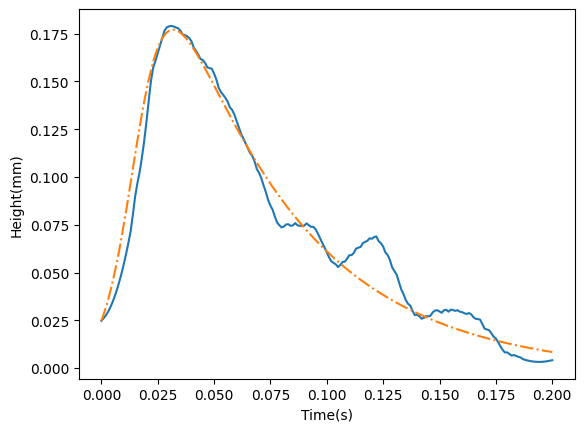

In [7]:
train, model = SINDY(x,t,thresh,wl)
model.print()
x_hat = model.simulate(train[0],t)#[:,0]
focus_idx = np.array([1,2,4,5])

plt.plot(t,train[:,1])
plt.plot(t,x_hat[:,1], '-.')

plt.xlabel('Time(s)')
plt.ylabel('Height(mm)')
plt.plot()
params = model.coefficients()[-1]
print(f"Recovered Parameter Values = \n {params[focus_idx]}")
print(f"RMSE = {mean_squared_error(train[:,1], x_hat[:,1], squared = False)}")

In [8]:
import numpy as np

def sample_and_extrapolate(array, time_array, num_samples):
    # Remove first and last row of the array and the corresponding time
    f_arr,l_arr = array[0],array[-1]
    f_time,l_time = time_array[0], time_array[-1]
    
    array_,time_array_ = np.copy(array),np.copy(time_array)
    
    array = array[1:-1]
    time_array = time_array[1:-1]
    
    # Randomly sample from the remaining array based on num_samples
    sampled_indices = sort_matrix(np.random.choice(len(array), size=num_samples, replace=False)).reshape(-1)
    sampled_array = array[sampled_indices]
    sampled_time = time_array[sampled_indices]
    
    # Add previously removed first and last row back to the array
    sampled_array = np.concatenate(([f_arr], sampled_array, [l_arr]))
    sampled_time = np.concatenate(([f_time], sampled_time, [l_time]))
    
    
    # Extrapolate for all time in the time array
    interpolated_array = np.interp(time_array_, sampled_time , sampled_array)

    return interpolated_array
x_xtrap = sample_and_extrapolate(x,t,int(0.5*len(x)))
len(x_xtrap)

201

In [9]:
# Bootstrap the data points
Lt_data = np.vstack((x,t)).T
n_bootstraps = 3000
bootstrap_params = np.zeros((n_bootstraps, len(params)))
bootstrap_set = []
Differential_set = []

for i in tqdm(range(n_bootstraps)):
    #bootstrap data
    bootstrap_data = sample_and_extrapolate(x,t,int(0.6*len(x)))
    
    #differentiate the data to get dl/dt
    diff_data = smoothed_fd(bootstrap_data,t)
    
    #append bootstrap data and their differentiation into a matrix
    bootstrap_set.append(bootstrap_data)
    Differential_set.append(diff_data)
    
    #Fit Sindy to bootstrapped data for prior paramaters
    tmp, sindy = SINDY(bootstrap_data,t,thresh,wl)
    sindy_params =  sindy.coefficients()[-1]
    
    #append the params to parameter list
    bootstrap_params[i,:] = sindy_params
    
#Convert list to array    
bootstrap_set = np.array(bootstrap_set)
Differential_set = np.array(Differential_set)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:29<00:00, 101.47it/s]


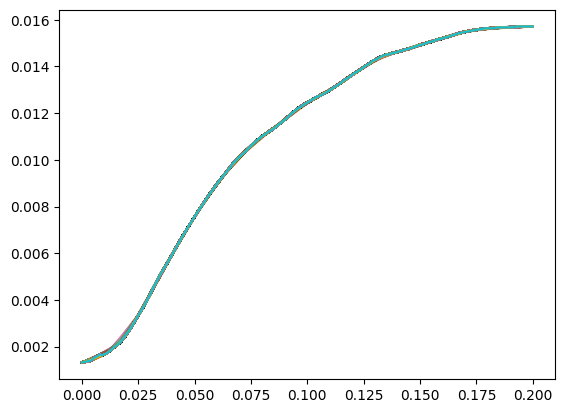

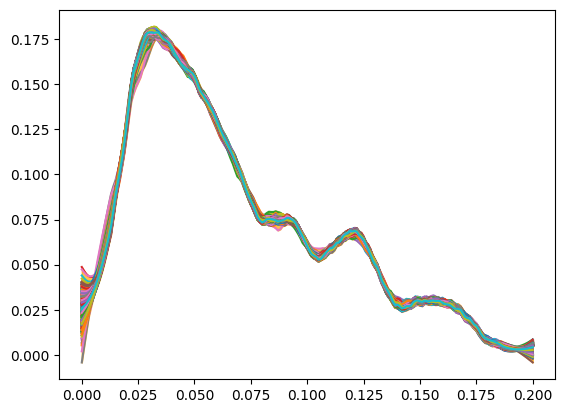

In [10]:
# Plot distribution for bootstrap data
for i in range(len(bootstrap_set)):
    plt.plot(t, bootstrap_set[i])
plt.fill_between(t, bootstrap_set.min(0), bootstrap_set.max(0), alpha=0.7, color='orange')   
plt.show()

# Plot distribution for differentiated bootstrap data
for i in range(len(Differential_set)):
    plt.plot(t, Differential_set[i])
plt.fill_between(t, Differential_set.min(0), Differential_set.max(0), alpha=0.7, color='orange')   
plt.show()



In [11]:
#Print Values from of parameters 
print("mean of the parameters = ", np.mean(bootstrap_params,0)) #mean of Sindy learned bootstraped data parameters
print("All data mean = ", params) # Recovered parameter using all data
print("mode of the parameters = ", scipy.stats.mode(bootstrap_params,axis=0).mode) #mode of bootstrap parameters

mean of the parameters =  [ 6.18934192e-03  1.61792431e+01  1.23915194e+02  3.80437476e+01
 -9.61466219e+03 -4.20061027e+02]
All data mean =  [ 0.00000000e+00 -3.45534029e+00  1.54509129e+02  0.00000000e+00
 -1.06599397e+04 -5.78295008e+02]
mode of the parameters =  [[     0.          -1515.78882801      0.              0.
  -11168.81504918      0.        ]]


# Stochastic Inverse Problem Analysis

### Helper functions for the Stochastic Inverse Problem

In [12]:
# Recovered Model for d2l/dt2 from SINDy
def inf_func(y0,t, params):
    L,dL = y0
    L_dot = 1.0 * dL
    dL_dot = params[0]*1 + params[1]*L + params[2]*dL + params[3]*L**2 + params[4]*L*dL + params[5]*dL**2
    return [L_dot,dL_dot] 

# Integrating Function calling the model
def intgrt(params, y0 = intial_vals):
    t_up = obs_time[-1]
    t_eval = np.linspace(0,t_up,len(obs_time))    
    integral = odeint(inf_func, y0=y0, t=t_eval, args = (params,))
    return integral

In [13]:
def Prior(mean = params, std=np.ones(len(params))*1): #std_feat
    """Generates a single sample from the prior distribution with the specified mean and covariance matrix"""
    
    sz = len(mean)
    if sz > 4:
        cov = np.diag(std,0)
    else:
        cov = np.diag(np.ones(len(mean))*1,0)
    params = np.random.multivariate_normal(mean, cov, size = 1)
    return params.reshape(-1)


def Generate_priors(n_samples=10000, mean = params, std = np.ones(len(params))*1):
    """Function for Generating multiple samples from the prior
    it samples from n_samples times from the given prior distribution above and then add random samples from the 
    bootstrapped parameter samples"""
    
    prior_params = []
    for i in tqdm(range(n_samples)):
        prior_params.append(Prior(mean,std ))
    prior_params = np.array(prior_params)
#     prior_params = np.vstack((prior_params,featuring_params))
    prior_params = prior_params[np.random.permutation(prior_params.shape[0])]
    return prior_params


def Q(params, F=True):
    """Function for Generating Model Output"""
    sz = len(params)
    QoI = intgrt(params)[:,1]
    if F:
        return QoI.flatten()  
    else:
        return QoI

### Kernel Density Estimator For the Observed Data Density

In [14]:
# Kernel Density estimates from bootsrapped data
train = dldt
KDE_Dataset_sindy = []
KDE_Dataset_sindy.append(dldt.flatten())
Dist_params_sindy = []
for i in tqdm(range(len(bootstrap_params))):
    response = intgrt(bootstrap_params[i])
#     response = response.flatten()
    mse = mean_squared_error(train, response[:,1], squared = False)
    # Specify mse value range for the accepted response
    if mse<0.015:
        KDE_Dataset_sindy.append(response[:,1])
        Dist_params_sindy.append(bootstrap_params[i])
        
KDE_Dataset_sindy = np.array(KDE_Dataset_sindy)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 501.66it/s]


In [15]:
vector_length = len(obs_height) #Specifying vector length for acceptance probability calculation

def kde_obs_sindy(X, i=vector_length):
    # Fit a kernel density estimator to the KDE_Dataset_sindy
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(KDE_Dataset_sindy[:,:i])
    pds = np.exp(kde.score_samples(X[:,:i]))
    return pds

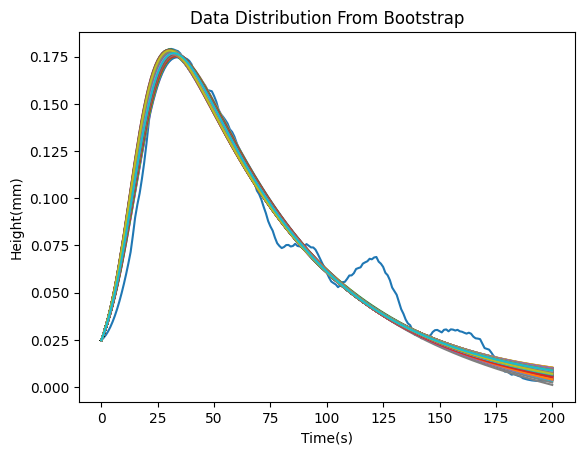

In [16]:
#plot KDE Dataset from SINDy
for i in range(len(KDE_Dataset_sindy)):
    plt.plot(KDE_Dataset_sindy[i])
    
plt.xlabel('Time(s)')
plt.ylabel('Height(mm)')
plt.title("Data Distribution From Bootstrap")
plt.plot()
plt.show()

In [17]:
#Estimating a Different Kernel Density from Bootstrapped KDE dataset
KDE_Dataset = Differential_set

def kde_obs(X, i=vector_length):
    # Fit a kernel density estimator to the KDE_Dataset
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(KDE_Dataset[:,:i])
    pds = np.exp(kde.score_samples(X[:,:i]))
    return pds

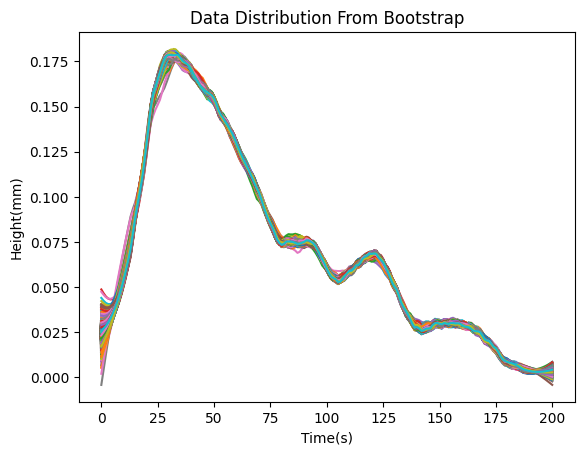

In [18]:
#plot Distribution
for i in range(len(KDE_Dataset)):
    plt.plot(KDE_Dataset[i])
    
plt.xlabel('Time(s)')
plt.ylabel('Height(mm)')
plt.title("Data Distribution From Bootstrap")
plt.plot()
plt.show()

In [19]:
#Print the mean of and mode of the parameters of the observed distribution from sindy

print("mean of the parameters = \n ", np.mean(Dist_params_sindy,0))
print("All data mean = \n ", params) # Recovered parameter using all data
print("mode of the parameters = \n ", scipy.stats.mode(Dist_params_sindy,axis=0).mode)

mean of the parameters = 
  [ 0.00000000e+00 -4.95104086e+00  1.55378253e+02  0.00000000e+00
 -1.06685564e+04 -5.83770160e+02]
All data mean = 
  [ 0.00000000e+00 -3.45534029e+00  1.54509129e+02  0.00000000e+00
 -1.06599397e+04 -5.78295008e+02]
mode of the parameters = 
  [[     0.            -20.30266707    142.36484131      0.
  -11168.81504918   -647.29435328]]


### Generating prior samples, Pushforward of this priors, and a Kernel Density Estimator for the pushforward

In [20]:

#Generate n Prior samples
mu =  np.mean(Dist_params_sindy,0) #np.array([0,-4,150,0,-10700,-580])#
std = 50**2
Prior_Samples = Generate_priors(10000,mu,np.ones(len(mu))*std)

# Generate the Push forward of the prior
Push_forward_of_Prior = []
for i in tqdm(range(len(Prior_Samples))):
    Push_forward_of_Prior.append(Q(Prior_Samples[i]))
Push_forward_of_Prior = np.array(Push_forward_of_Prior)

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\USER\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:09<00:00, 143.45it/s]


In [21]:
# Prior_kde function using same vector length used for the data kde
def prior_kde(X, dat=Push_forward_of_Prior, i=vector_length):
    """Fits a kernel density estimator to the datapoint up until the (i+1)th term"""
    # Fit a kernel density estimator to the KDE_Dataset
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(dat[:,:i])
    if len(X.shape)<2:
        X=X.reshape(1,-1)
    pds = np.exp(kde.score_samples(X[:,:i]))
    return pds

# Reweighting Factor r(lamda)
def r_ratio(Push_forward_Data):
    r_prior = prior_kde(Push_forward_Data)
    r_obs = kde_obs_sindy(Push_forward_Data)
    ratios = r_obs/r_prior
    m = max(ratios)
    return m,ratios

### Rejection Sampling Algorithm

In [22]:
# Calling the Reweighting Factor function to find M and Lamda values of the prior parameters
M, Lamda_values = r_ratio(Push_forward_of_Prior) 

In [23]:
#Iterating to accept or reject lamdas in the prior
Accepted_lamda = []
Index = []
for p in range(len(Lamda_values)):
    r_p = Lamda_values[p]
    xi_p = np.random.uniform()
    eta_p = r_p/M
    if eta_p > xi_p:
        Accepted_lamda.append(Prior_Samples[p])
        Index.append(p)
Accepted_lamda = np.array(Accepted_lamda)
Index = np.array(Index)
Index[:].shape

(66,)

In [24]:
# Compute Pushforward of the posterior
Push_forward_of_Posterior = []
for i in tqdm(range(len(Accepted_lamda))):
    Push_forward_of_Posterior.append(Q(Accepted_lamda[i]))
Push_forward_of_Posterior = np.array(Push_forward_of_Posterior)    

100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 376.01it/s]


In [25]:
def plot_matrix_distribution(matrix, labels, y_label= ["Density"]*50):
    """
    Plots the distribution of each column of a matrix using a kernel density estimation.
    Each distribution is plotted in a separate figure vertically stacked on top of each other.
    
    Parameters:
        matrix (numpy.ndarray): Input matrix with shape (n_rows, n_cols).
        labels (list): List of strings containing the labels for each column.
    """
    min_lim =  np.min(np.min(matrix, axis=0))
    max_lim =  np.max(np.max(matrix, axis=0))
    
    # Create a separate plot for each column
    for i in range(matrix.shape[1]):
        fig, ax = plt.subplots(figsize=(3, 1.5))
        min_lim = np.min(matrix[:,i], axis=0)
        max_lim = np.max(matrix[:,i], axis=0)
        
        # Fit a kernel density estimator for the column
        kde = sns.kdeplot(matrix[:, i], bw_adjust=0.5, shade=True, color="brown", ax=ax)
        
        # Set plot aesthetics
        sns.despine(left=True, ax=ax)
        ax.set_xlabel(f"$\mu$ = {np.mean(matrix[:,i]).round(3)}")
        ax.set_ylabel(y_label[i])
        ax.set_yticks([])
        ax.set_xlim(min_lim,max_lim)
        
        # Add a vertical dashed line at the zero point of the x-axis
        ax.axvline(x=0, linestyle='--', color='black', alpha=0.8)
        
        plt.tight_layout()
        
        # Show the plot
        plt.show()

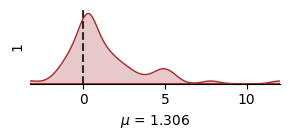

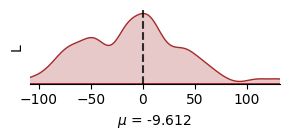

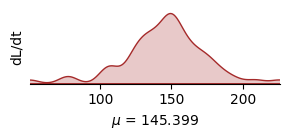

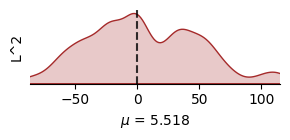

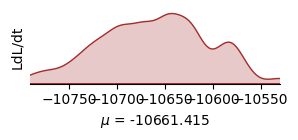

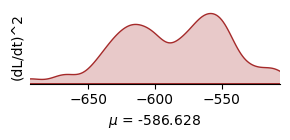

In [26]:
labels =  ['1','L','dL/dt','L^2','LdL/dt','(dL/dt)^2' ]
y_label = ['1','L','dL/dt','L^2','LdL/dt','(dL/dt)^2' ]
plot_matrix_distribution(Accepted_lamda[:], labels, y_label)

In [27]:
# Compare mean Prior and Posterior samples of the parameters
print(f"Prior mean, sigma = \n {np.mean(Prior_Samples, 0).round(2)} \n {np.std(Prior_Samples, 0).round(2)} \n")
print(f"Posterior mean = \n {np.mean(Accepted_lamda,0).round(2)} \n {np.std(Accepted_lamda, 0).round(2)} \n")

Prior mean, sigma = 
 [-4.000000e-02 -5.250000e+00  1.564600e+02  1.400000e-01 -1.066872e+04
 -5.834600e+02] 
 [50.4  50.11 49.67 50.23 49.91 50.29] 

Posterior mean = 
 [ 1.310000e+00 -9.610000e+00  1.454000e+02  5.520000e+00 -1.066141e+04
 -5.866300e+02] 
 [ 2.41 48.1  29.07 44.68 56.14 40.21] 



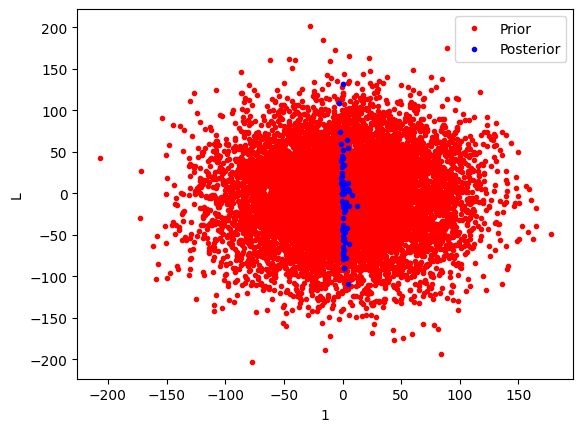

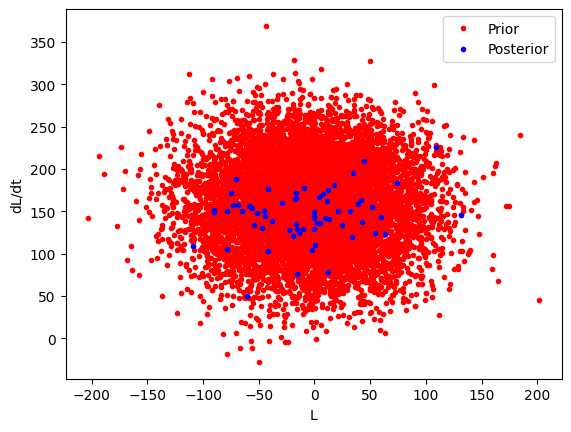

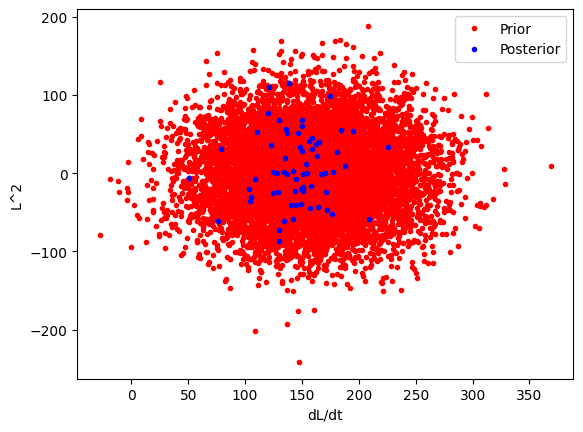

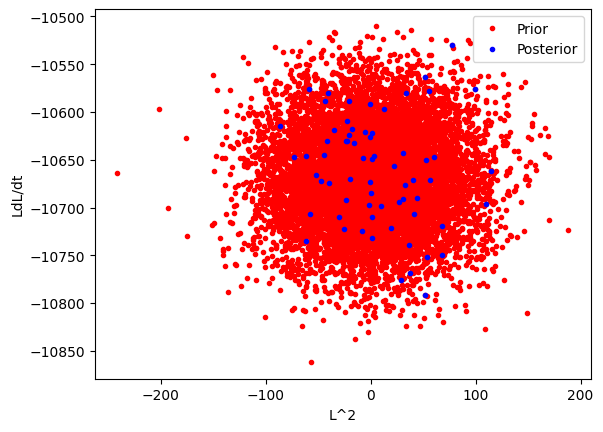

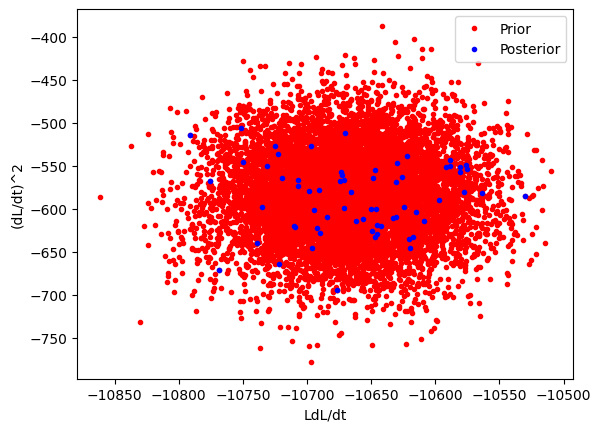

In [28]:
#Scatter plots of Prior and Posterior samples for each parameter
accpt_par = Accepted_lamda#[:,focus_idx]
prior_par = Prior_Samples#[:,focus_idx] 
lab_par = np.array(labels)#[focus_idx]
for a in range(len(lab_par)):
    for b in range(len(lab_par)):
        if b==a+1:
            plt.plot(prior_par[:,a],prior_par[:,b],'r.', label='Prior')
            plt.plot(accpt_par[:,a],accpt_par[:,b],'b.',label='Posterior')
            plt.legend()
            plt.xlabel(lab_par[a])
            plt.ylabel(lab_par[b])
            plt.show()

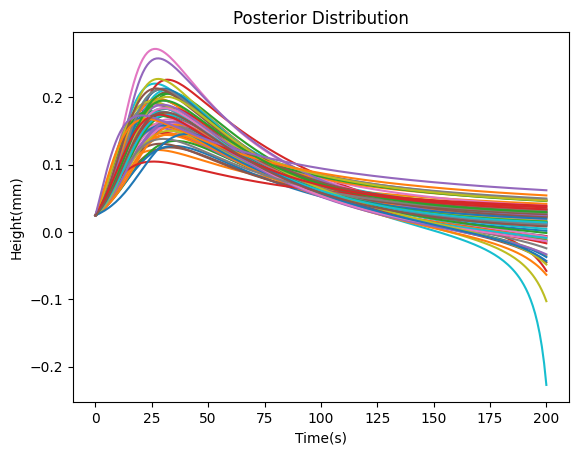

In [29]:
# Plot pushforward distribution
for i in range(len(Push_forward_of_Posterior)):
    plt.plot(Push_forward_of_Posterior[i])

plt.xlabel('Time(s)')
plt.ylabel('Height(mm)')
plt.title("Posterior Distribution")
plt.plot()
plt.show()

In [30]:
labels = ['1','2','3','4','5','6','7','8','9','10','11','12']
def plot_normal(mu = 0, sigma=1, label = labels , title ='Normal Distribution'):
    mu = np.array(mu).reshape(-1,1)
    if len(mu)>1:
        clr = ['b','r','g','k','yellow','orange','pink']
        mu = mu.reshape(-1)
        x_vals = []
        pdf_vals =[]
        for i in range(len(mu)):
            x_i = np.linspace(mu[i] - 4*sigma[i], mu[i] + 4*sigma[i], 1000)
            pdf_i = 1/(sigma[i] * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_i - mu[i])/sigma[i])**2)
            integral = np.trapz(pdf_i, x_i)
#             print(integral)
            pdf_i = pdf_i / integral
            x_vals.append(x_i)
            pdf_vals.append(pdf_i)
            
        # Create a plot of the normal distribution
        fig, ax = plt.subplots()
        for i in range(len(x_vals)):
            ax.plot(x_vals[i], pdf_vals[i], color=clr[i], lw=2, label = label[i])
        ax.set_xlabel('$\lambda$')
        ax.set_ylabel('PDF')
        ax.set_title(title)
        ax.legend()
        plt.show()    
    
    else:
        mu = mu.reshape(-1)
        x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
        pdf = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu)/sigma)**2)
        integral = np.trapz(pdf, x)
        pdf = pdf / integral
        
          # Create a plot of the normal distribution
        fig, ax = plt.subplots()
        ax.plot(x, pdf, color=color, lw=2)
        ax.set_xlabel('$\lambda$')
        ax.set_ylabel('PDF')
        ax.set_title(title)
        plt.show()

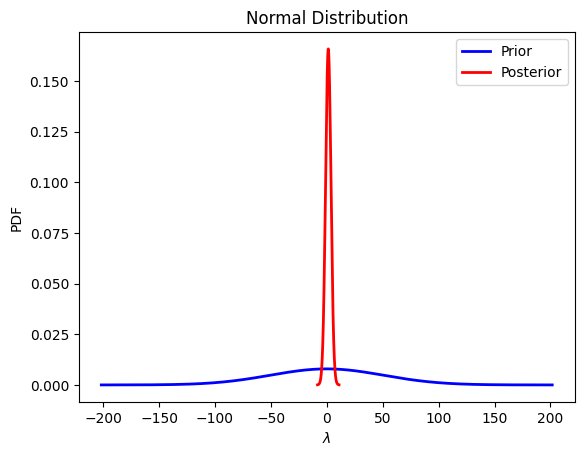

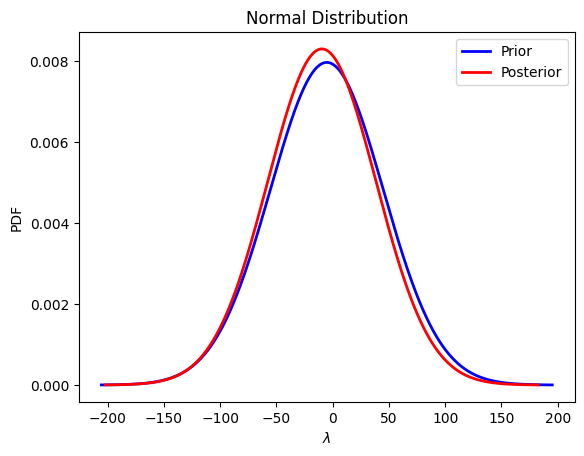

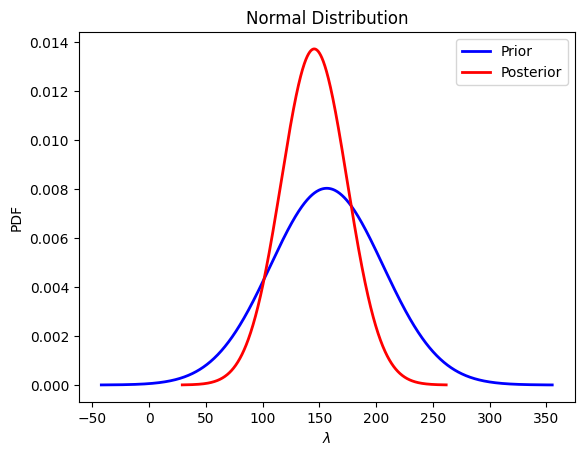

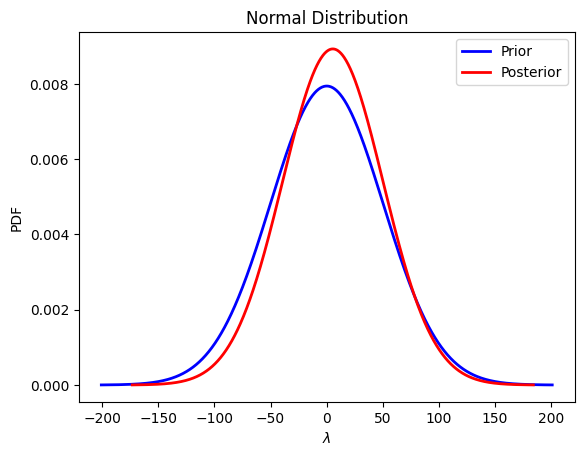

In [31]:

n=Accepted_lamda.shape[0]
for i in range(4):
    labels = ['Prior', 'Posterior', 'True']
    pr_vals = Prior_Samples[:,i] 
    ac_vals = Accepted_lamda[:,i]
    
    mu_pr,std_pr = np.mean(pr_vals),np.std(pr_vals)
    mu_ac,std_ac = np.mean(ac_vals),np.std(ac_vals)
    
    mu_gen = np.array([mu_pr,mu_ac])
    std_gen = np.array([std_pr,std_ac])
    plot_normal(mu = mu_gen, sigma=std_gen, label = labels , title ='Normal Distribution')
    

In [32]:
# Posterior_kde
def posterior_kde(X=Push_forward_of_Posterior, dat=Push_forward_of_Posterior ,i=10):
    """Fits a kernel density estimator to the datapoint up until the (i+1)th term"""
    # Fit a kernel density estimator to the KDE_Dataset
    post_kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(dat[:,:i])
    if len(X.shape)<2:
        X=X.reshape(1,-1)
    pds = np.exp(post_kde.score_samples(X[:,:i]))
    return pds

In [33]:
def extract_column_k(Data, k=0):
    combine = []
    for i in range(len(Data)):
        data = Data[i]
        combine.append(data[:,k])
    combine = np.array(combine)
    return combine.T

# p_prior = Push_forward_of_Prior
# p_post = Push_forward_of_Posterior

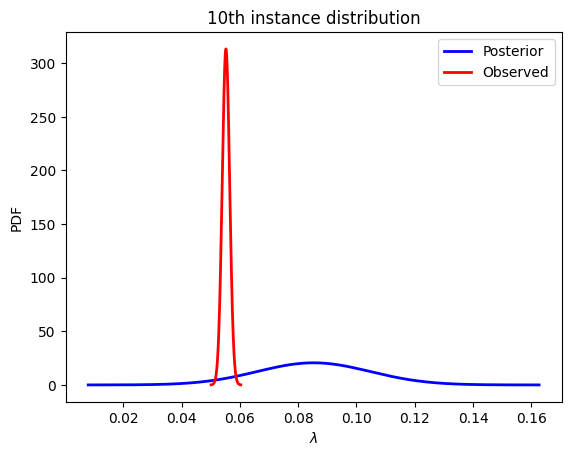

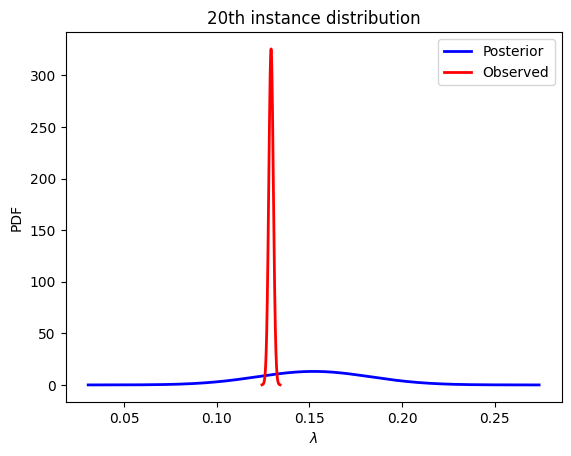

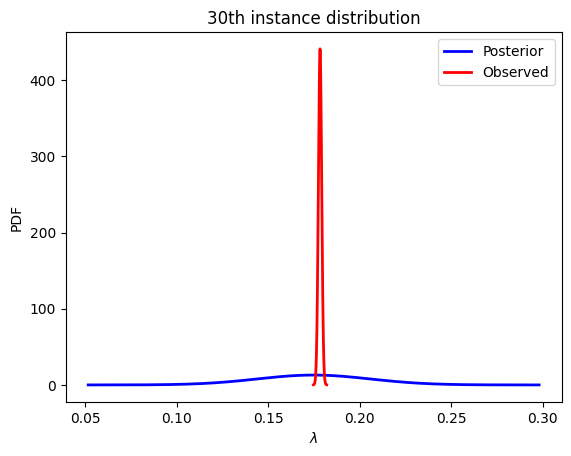

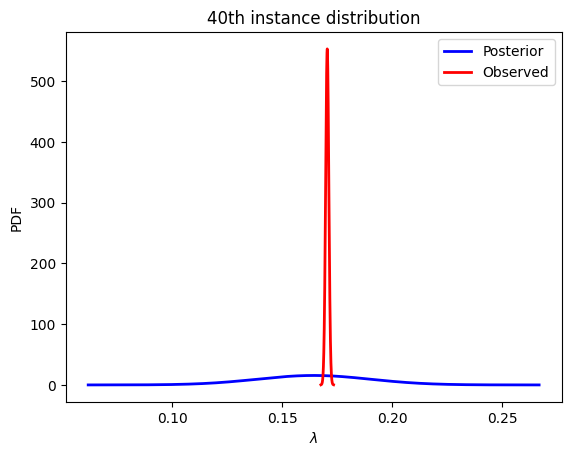

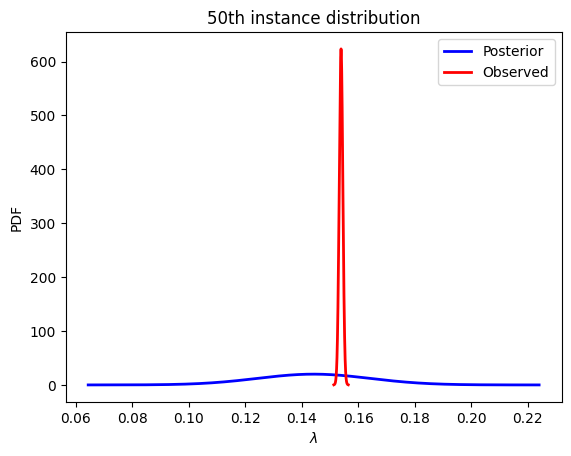

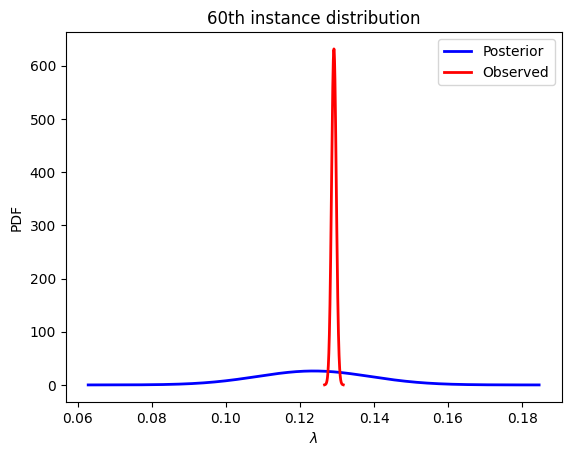

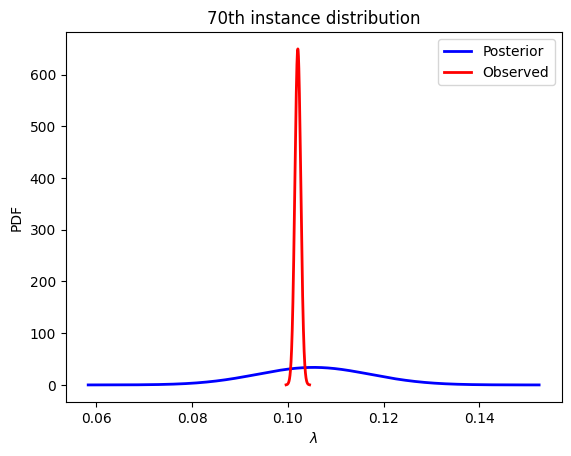

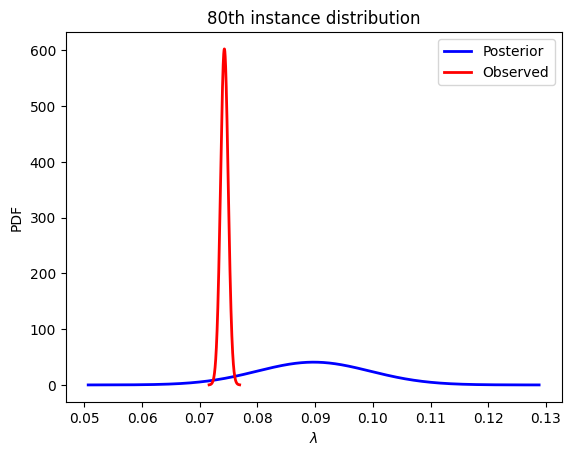

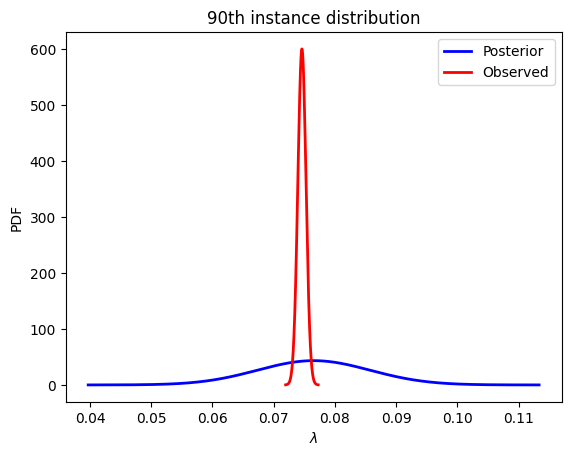

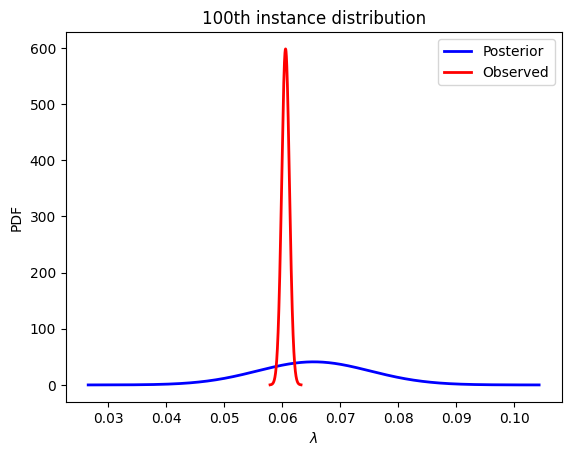

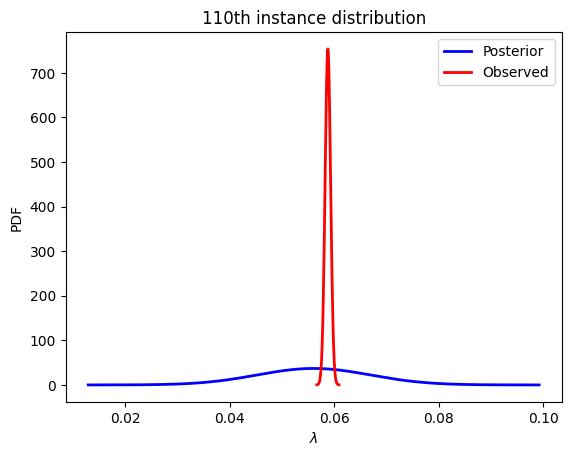

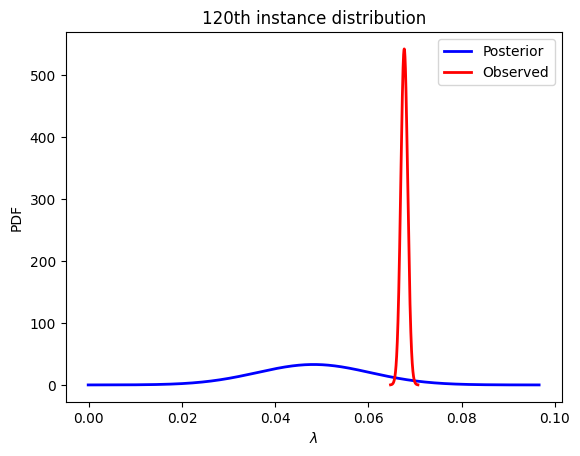

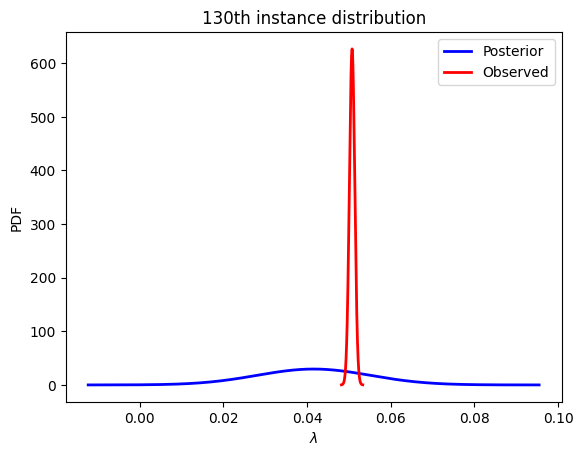

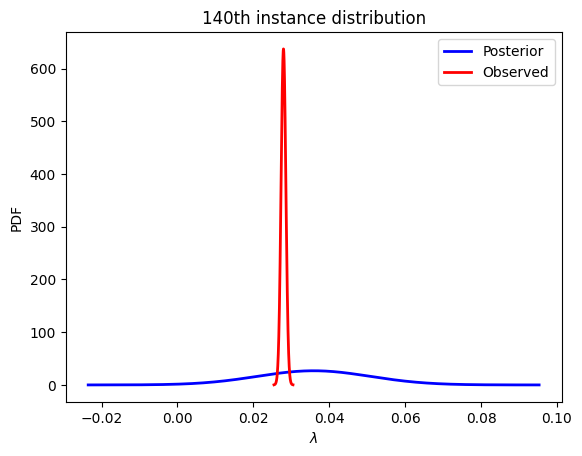

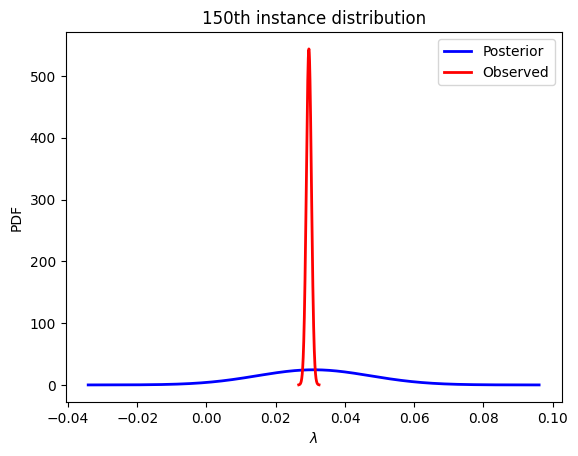

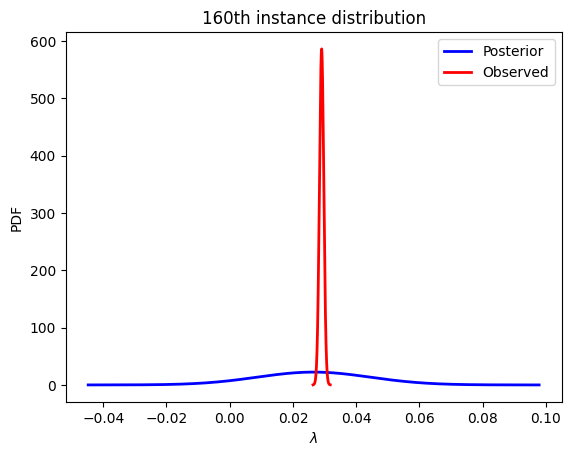

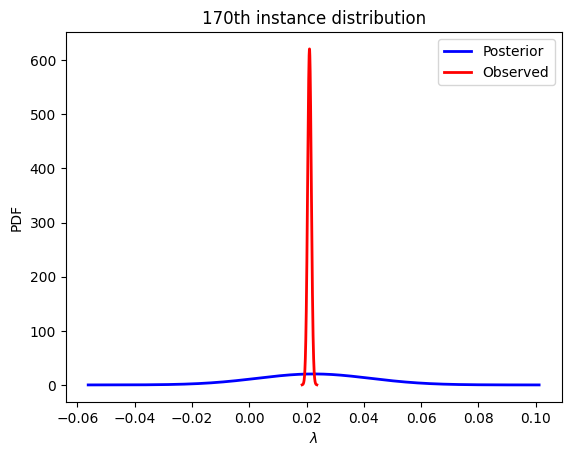

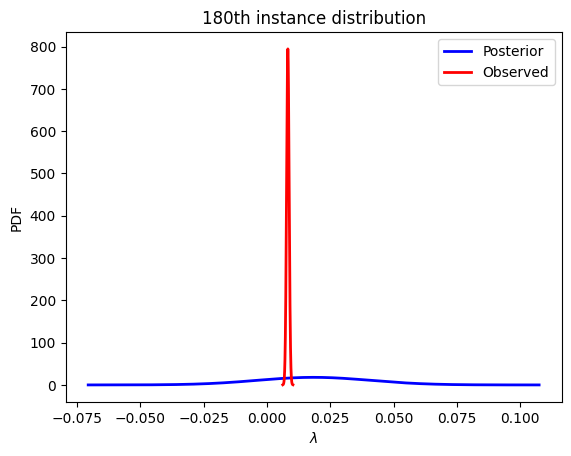

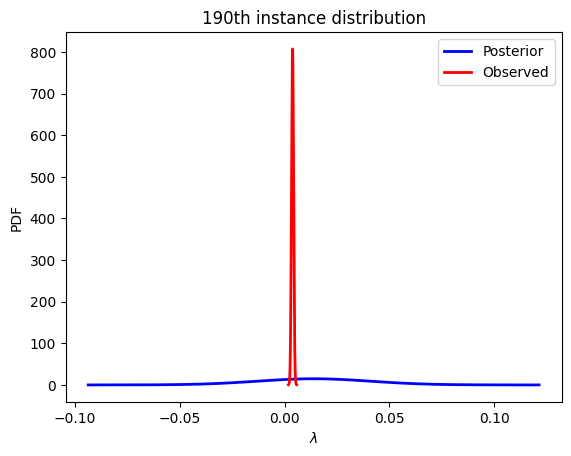

In [34]:
for k in range(10,200,10):
    post_prior = extract_column_k([Push_forward_of_Posterior, KDE_Dataset[:len(Push_forward_of_Posterior)]], k=k)
    plot_normal(np.mean(post_prior, axis=0),np.std(post_prior, axis=0), ['Posterior','Observed'], f'{k}th instance distribution')
# plot_multivariate_normal(post_prior, 'Alpha', 'Beta', 'Recovered')

# Continuous Sampling Until M Samples Accepted

### Adaptive Sampling

In [35]:
# featuring_params = Dist_params
#Generate n Prior samples
mu =  np.mean(Dist_params_sindy,0)#np.array([0,-4,150,0,-10700,-580])#
Prior_Samples = Generate_priors(10000,mu,np.ones(len(mu))*100)

# Generating the Push forward of the prior
Push_forward_of_Prior = []
for i in tqdm(range(len(Prior_Samples))):
    Push_forward_of_Prior.append(Q(Prior_Samples[i]))
Push_forward_of_Prior = np.array(Push_forward_of_Prior)

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\USER\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.31it/s]


In [36]:
N_accepted = []
l_sz = len(params)
mean_ = np.zeros(l_sz)
std_ = np.ones(l_sz)*10000.0
while len(N_accepted) < 25000: 
    print(len(N_accepted))
    #Generate 5,000 Prior samples
    if len(N_accepted)<10:
        Prior_Samples = Generate_priors(2000, np.zeros(l_sz), np.ones(l_sz)*1000.0) #prior_feat_mean, std_feat )
    else:
        Prior_Samples = Generate_priors(1000, mean_, std_ )

    # Generating the Push forward of the prior

    Push_forward_of_Prior = []
    for i in tqdm(range(len(Prior_Samples))):
        Push_forward_of_Prior.append(Q(Prior_Samples[i]))
    Push_forward_of_Prior = np.array(Push_forward_of_Prior)

    # Prior_kde function using same vector length used for the data kde
    def prior_kde(X, dat=Push_forward_of_Prior, i=vector_length):
        """Fits a kernel density estimator to the datapoint up until the (i+1)th term"""
        # Fit a kernel density estimator to the KDE_Dataset
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(dat[:,:i])
        if len(X.shape)<2:
            X=X.reshape(1,-1)
        pds = np.exp(kde.score_samples(X[:,:i]))
        return pds

    # The ratio function
    def r_ratio(lamda):
        qoi = Q(lamda)
        obs_density = kde_obs(qoi)
        prior_density = prior_kde(qoi)
        return obs_density/prior_density

    # Generating the r values for all the points in the prior sample
    Lamda_values = []
    for i in tqdm(range(len(Prior_Samples))):
        lamda = Prior_Samples[i]
        r_value = r_ratio(lamda)
        Lamda_values.append(r_value)

    Lamda_values = np.array(Lamda_values)  

    M = max(Lamda_values)
#     N_accepted = []
    Index = []
    for p in range(len(Lamda_values)):
        r_p = Lamda_values[p]
        xi_p = np.random.uniform()
        eta_p = r_p/M
        if eta_p > xi_p:
            N_accepted.append(Prior_Samples[p])
            Index.append(p)
    ntemp =  int(len(N_accepted)*0.66)
    mean_= np.mean(np.array(N_accepted[ntemp:]),axis=0)
    std_ = np.std(np.array(N_accepted[ntemp:]),axis=0)
            
N_accepted = np.array(N_accepted)
Index = np.array(Index)
Index[:].shape    

0


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
np.mean(np.array(N_accepted[10:]),axis=0)

In [ ]:
np.mean(featuring_params,0)

In [ ]:
import scipy
scipy.stats.mode(np.array(N_accepted[:]).round(2),axis=0).mode

In [ ]:
N_accepted = np.array(N_accepted)
labels = ['alpha', 'beta', 'delta', 'gamma']
y_label = ['u','uv','v','uv']
plot_matrix_distribution(N_accepted[:], labels, y_label)

In [ ]:
# Pushforward of the posterior
Push_forward_of_Posterior = []
NA = N_accepted[100:]
for i in tqdm(range(len(NA))):
    Push_forward_of_Posterior.append(Q(NA[i]))
Push_forward_of_Posterior = np.array(Push_forward_of_Posterior)    

In [ ]:
plot_multivariate_normal(N_accepted[100:,:2], 'Alpha', 'Beta', 'Recovered')
plot_multivariate_normal(featuring_params[:,:2], 'Alpha', 'Beta', 'True')
plot_multivariate_normal(N_accepted[100:,2:], 'Gamma', 'Delta', 'Recovered')
plot_multivariate_normal(featuring_params[:,2:], 'Gamma', 'Delta', 'True')


plot_multivariate_normal(N_accepted[100:,[0,2]], 'Alpha', 'Gamma', 'Recovered')
plot_multivariate_normal(featuring_params[:,[0,2]], 'Alpha', 'Gamma', 'True')
plot_multivariate_normal(N_accepted[100:,[0,3]], 'Alpha', 'Delta', 'Recovered')
plot_multivariate_normal(featuring_params[:,[0,3]], 'Alpha', 'Delta', 'True')

In [ ]:
n=N_accepted.shape[0]
for i in range(4):
    labels = ['Prior', 'Posterior', 'True']
    pr_vals = Prior_Samples[:n,i] 
    ac_vals = N_accepted[100:n,i]
    tr_vals = featuring_params[:n,i]
    
    mu_pr,std_pr = np.mean(pr_vals),np.std(pr_vals)
    mu_ac,std_ac = np.mean(ac_vals),np.std(ac_vals)
    mu_tr,std_tr = np.mean(tr_vals),np.std(tr_vals)
    mu_gen = np.array([mu_pr,mu_ac,mu_tr])
    std_gen = np.array([std_pr,std_ac,std_tr])
    plot_normal(mu = mu_gen, sigma=std_gen, label = labels , title ='Normal Distribution')
    

In [ ]:
for k in range(10,200,10):
    post_prior = extract_column_k([Push_forward_of_Posterior, KDE_Dataset[:len(Push_forward_of_Posterior)]], k=k)
    plot_normal(np.mean(post_prior, axis=0),np.std(post_prior, axis=0), ['Posterior','Observed'], f'{k}th instance distribution')
# plot_multivariate_normal(post_prior, 'Alpha', 'Beta', 'Recovered')

In [ ]:
plt.plot(Prior_Samples[:,0],Prior_Samples[:,1],'r.', label='Prior')
plt.plot(featuring_params[:,0],featuring_params[:,1],'g.',label='True')
plt.plot(N_accepted[50:,0],N_accepted[50:,1],'b.',label='Posterior')
plt.legend()
plt.show()


plt.plot(Prior_Samples[:,2],Prior_Samples[:,3],'r.', label='Prior')
plt.plot(N_accepted[50:,2],N_accepted[50:,3],'b.',label='Posterior')
plt.plot(featuring_params[:,2],featuring_params[:,3],'g.',label='True')

plt.legend()
plt.show()

# Extended Library

In [37]:
import warnings
from collections import OrderedDict
import pandas as pd

import scipy
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.utils import resample
import pysindy as ps
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from scipy.integrate import odeint
from scipy.stats import multivariate_normal
import seaborn as sns



from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

from sklearn.metrics import mean_squared_error
# mean_squared_error(obs_height, pred_param_height[k2], squared = False)

In [38]:
## Upsampling Function
def resample_data(data, scale = int(200/35)):
    """Code function to either upsample or downsample a dataset depending on the factor"""
    
    def upsample(original_data, factor = 2):
        # Upsampling factor
        upsampling_factor = factor

        # Calculate new number of samples
        new_num_samples = len(original_data) * upsampling_factor

        # Generate new indices for the upsampled data
        new_indices = np.linspace(0, len(original_data) - 1, new_num_samples)

        # Upsample the data
        upsampled_data = np.interp(new_indices, np.arange(len(original_data)), original_data)
        return upsampled_data
    
    
    sz = data.shape
    
    if len(sz) < 2:
        upsampled_data = upsample(data.reshape(-1),scale)
        return upsampled_data
        
    else:
        Data = []
        for i in range(sz[-1]):
            data_i = data[:,i].reshape(-1)
            upsampled_i = upsample(data_i, scale)
            Data.append(upsampled_i)
        Data = np.asarray(Data).T
        return Data

def SINDY(noisy_data, t, threshold = 0.03, wl = 15, condit = False):
    """Fits SINDy model to a data and returns the resulting coefficients"""
    Poly_lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=True)
    optimizer = ps.STLSQ(threshold)#threshold = 0.3)
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(noisy_data,t)
    L_dl = np.vstack((noisy_data,dldt)).T

    model = ps.SINDy(
        differentiation_method=smoothed_fd,
        feature_library=Poly_lib,
        optimizer=optimizer,
        feature_names=["L", "dL"] 
    )
    if condit: 
        model.fit(L_dl, t)
        model.print()
        model.get_feature_names()
        return model.coefficients()#.reshape(-1)
    
    else:
        model.fit(L_dl, t)
        return L_dl, model
        

def sort_matrix(matrix, col_idx = -1):
    """Sorts the element of a matrix by a predifine column in ascending order"""
    if len(matrix.shape)  == 1:
        matrix= matrix.reshape(-1,1)
    # Sort the matrix by the specified column
    sorted_matrix = sorted(matrix, key=lambda x: x[col_idx])
    return np.array(sorted_matrix)


def split_matrix(matrix):
    """Splits the last column of a matrix from the original matrix and returns the new matrix and the column"""
    matrix = matrix.tolist()
    # Split the last column from the matrix
    last_column = [row.pop() for row in matrix]
    return np.array(matrix),np.array(last_column)

def min_idx(arr1,arr2):
    """Finds the minimum of arr2 and return the corresponding arr1 values with it """
#     arr2 = arr2.tolist()
    min_value = min(arr2)
    min_index = arr2.index(min_value)
    return ([arr1[min_index],min_value])

def differentiate(data, time, wl=15):
    """Function to carry out numerical differentiation with respect to time using smoothed finite difference"""
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(data,time)
    d2ldt = smoothed_fd(dldt, time)
    d3ldt = smoothed_fd(d2ldt, time)
    return dldt,d2ldt,d3ldt

# Code to generate publication worthy images 
def plt_figures(rows=1, cols=1, fontsize=20, figsize=(10, 6), dpi=600):
    import matplotlib as mpl

    # Setting global parameters
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.titlesize'] = fontsize  # Setting title font size same as other fonts
    mpl.rcParams['legend.fontsize'] = fontsize
    
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'  # 'Times New Roman'

    fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=dpi)
    
    return ax

In [39]:
class My_STLSQ:
    def __init__(self, threshold=0.05, fit_intcpt = True):
        self.threshold = threshold
        self.fit_intcpt = fit_intcpt  
                

    def fit(self, True_X, y):
        """
        Perform least squares regression with LASSO regularization
        Parameters:
        -----------
        True_X : numpy array
            Feature matrix of shape (n_samples, n_features)
        y : numpy array
            Response vector of shape (n_samples,)
        self.threshold : float
            LASSO regularization parameter

        Returns:
        --------
        coef : numpy array
            Coefficient vector of the final model
        """

        if self.fit_intcpt:
            # Add a bias term to the input data
            X_ = np.insert(True_X, 0, 1, axis=1)
        else: X_ = np.copy(True_X)

        if len(y.shape) == 1:
            y = y.reshape(-1,1)
            
        n_features = X_.shape[1]
        self.Coeffs = []
        for i in range(y.shape[-1]):
            X = np.copy(X_)
            y_i = y[:,i] 
            model = LinearRegression()
            coef = np.zeros(n_features)
            while True:
                model.fit(X, y_i)
                coef_new = model.coef_
                if np.max(np.abs(coef_new - coef)) < 1e-5:
                    break
                coef = coef_new
                small_coef = np.abs(coef) < self.threshold
                if np.sum(small_coef) == 0:
                    break
                X = X[:, ~small_coef]
                coef = coef[~small_coef]
            indx = find_indexes(X_[0],X[0])
            coefficient = np.zeros(n_features)
            coefficient[indx] = coef
            self.Coeffs.append(coefficient)
        return np.array(self.Coeffs)

    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Coeffs)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

    
    
class SequentialThresholdLeastSquares:
    """Sequential threshold based on correlation"""
    def __init__(self, threshold=0.05, fit_intcpt = False):
        self.threshold = threshold*10
        self.fit_intcpt = fit_intcpt  
                
    
    def fit(self, X, y, ):        
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1) 
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
        
        self.Beta = [] #np.zeroes(y.shape[-1],X.shape[-1])
        for t in range(y.shape[-1]):
            yt = y[:,t]
            # Initialize the parameter vector
            self.beta = np.zeros(X.shape[1])

            # Compute the initial residual and RSS
            r = yt - np.dot(X, self.beta)
            RSS = np.sum(r**2)

            # Iterate until convergence
            while True:
                # Compute the correlation coefficients
                corr = np.abs(np.dot(X.T, r))

                # Find the feature with the highest correlation
                j_star = np.argmax(corr)

                # Check if the highest correlation is above the threshold
                if corr[j_star] > self.threshold:
                    # Compute the new parameter estimate for feature j_star
                    beta_j_star = np.dot(X[:,j_star], r) / np.dot(X[:,j_star], X[:,j_star])

                    # Update the parameter vector and residual
                    self.beta[j_star] += beta_j_star
                    r -= beta_j_star * X[:,j_star]
                    RSS = np.sum(r**2)
                else:
                    break
            self.Beta.append(self.beta)
        return np.array(self.Beta)
    
    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Beta)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

def LR(X, y, alpha, n_features):
    model = LinearRegression()
    coef = np.zeros(n_features)
    while True:
        model.fit(X, y)
        coef_new = model.coef_
        if np.max(np.abs(coef_new - coef)) < 1e-5:
            break
        coef = coef_new
        small_coef = np.abs(coef) < self.threshold
        if np.sum(small_coef) == 0:
            break
        X = X[:, ~small_coef]
        coef = coef[~small_coef]
    return X,coef


def find_indexes(array, elements):
    if type(array) != list:
        array = array.tolist()
        
    elements = np.array(elements)
    indexes = []
    for element in elements:
        try:
            index = array.index(element)
            indexes.append(index)
        except ValueError:
            indexes.append(None)
    return indexes

def plot_multivariate_normal(data, xlabel='x', ylabel='y', title='Multivariate Normal Distribution'):
    # Compute the mean and covariance of the data
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)

    # Create a grid of points for the x and y axes
    x, y = np.mgrid[mean[0]-3*np.sqrt(cov[0,0]):mean[0]+3*np.sqrt(cov[0,0]):100j,
                    mean[1]-3*np.sqrt(cov[1,1]):mean[1]+3*np.sqrt(cov[1,1]):100j]

    # Create a multivariate normal distribution using the mean and covariance
    mvn = multivariate_normal(mean=mean, cov=cov)

    # Evaluate the PDF of the multivariate normal distribution at each point on the grid
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    pdf = mvn.pdf(pos)
    
    # Set the plot title and axis labels
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot the multivariate normal distribution as a contour plot
    ax.contourf(x, y, pdf)
    # Show the plot
    plt.show()

# The base infiltration $\underline{Governing \ Physics}$ is defined as
   - $\rho_lL\frac{d^2L}{dt^2} + \rho_l (\frac{dL}{dt})^2 + \frac{\mu}{K}L\frac{dL}{dt}+\rho_lgL = P_c$
   
   $\bf{The \ parameters \ are \ defined \ as \ follows}$
   - $\alpha = \rho_l \times g$
   - $\beta = \frac{\mu}{K}$
   - $\gamma = \delta = \rho_l\\$
   where $\rho_l$ is the fluid density; $\mu$ is the viscosity of fluid; $K$ is the permeability; $g$ is gravity and 
   $P_c$ = capillary pressure
   
## The enhanced infiltration $\underline{Governing \ Physics}$  including contact line friction is defined as
   - $\rho_lL\frac{d^2L}{dt^2} + \rho_l (\frac{dL}{dt})^2 + \frac{\mu}{K}L\frac{dL}{dt}+\rho_lgL + 2p\frac{\xi}{A}\frac{dL}{dt} = P_c\\$ 
   where $p$ is the meniscus perimeter, A is the cross sectional area, and $\underline{\xi}$ is the line of friction coefficient
   $\bf{Therefore, \ for \ simulation \ purpose, \ the \ parameters \ are \ redefined \ as \ follows}$ $\\$
   - $\alpha = \rho_l \times g$
   - $\beta = \frac{\mu}{K}$
   -  $\gamma = \delta = \rho_l$
   - $\nu = 2p\frac{\xi}{A} = \frac{4\xi}{R} \\$
   where $R$ is the radius of the tube

In [40]:
 ### Simulating Functions
def simulate_true_model(parameters, initial_vals, simu_time):
    """Function to simulate the true model given the parameters"""
    from scipy.integrate import odeint
    density,viscosity,permeability,gravity, capillary_pressure = parameters
    l0,v0 = initial_vals
    
    alpha = density*gravity
    beta  = viscosity/permeability
    gamma = density
    delta = density
    
    def infiltration_model(t, S):
        Pc = capillary_pressure
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated  

def simulate_extended_model(parameters, initial_vals, simu_time):
    """Function to simulate the true model given the parameters: Friction coefficient = (4xi)/R"""
    from scipy.integrate import odeint
    density, viscosity, permeability, gravity, capillary_pressure, friction_coefficient = parameters
    l0,v0 = initial_vals
    
    alpha = density*gravity
    beta  = viscosity/permeability
    gamma = density
    delta = density
    nu = friction_coefficient #(4 \xi/R)
    
    
    def extended_infiltration_model(t, S):
        Pc = capillary_pressure
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 + nu*v - Pc)
        return [v,dv]
    
    Simulated = odeint(extended_infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated  

# Simulate recovered model with extra term l^2
def simulate_recovered_model(parameters, initial_vals, simu_time, Pc):
    from scipy.integrate import odeint
    alpha, beta, delta, gamma, mu = parameters
    l0,v0 = initial_vals    
    def infiltration_model(t, S):
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 + mu*l**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated    

# Simulate recovered model with extra term l^2
def simulate_recovered_extended_model(parameters, initial_vals, simu_time, Pc):
    from scipy.integrate import odeint
    alpha, beta, delta, gamma, nu, mu = parameters
    l0,v0 = initial_vals    
    def extended_infiltration_model(t, S):
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 + nu*v + mu*l**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(extended_infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated 

# Load Dr Han's data

In [81]:
inf_data = pd.read_csv("Infiltration.csv")

obs_time = np.asarray(inf_data["Time (s)"])
obs_height = np.asarray(inf_data["Height (mm)"])/1000

t = np.copy(obs_time)
x = np.copy(obs_height)

a,b = x[0],x[1]
a,b = b,a
x[0],x[1] = a,b
# plt.plot(x)
# plt.plot(obs_height)

In [82]:
# Digitized parameters
viscosity = 8.9e-4 #0.5  #(Pa.s)
gravity = 9.81 #(m/s)
density =  997.77 # (kg/m3)
radius = 689 * 1e-6 #421 * 10**(-6) #(m)
jurin_height  = 7.1 * 1e-3 #10.4 * 10**(-3) #m 
surface_tension = 16.6 * 1e-3 #21.1 * 10**(-3) #N/m
# theta = get_theta(jurin_height, density, gravity, radius, surface_tension)
capillary_pressure = 184.93 #get_PC(surface_tension, theta, radius) # #jurin_height*density*g/ (np.cos(theta*0.5*np.pi/90)) #Pa
permeability = 3.78e-8 #radius**2/8 #R^2/8
# line_friction_coefficient = 13.5*(10**(-3))
# friction_coefficient = (4*line_friction_coefficient)/radius

print(f"Permeability = {permeability}")
print(f"Capillary pressure = {capillary_pressure}")
# print(f"Contact angle = {theta}")
# print(f"Friction_coefficient = {friction_coefficient}")

Permeability = 3.78e-08
Capillary pressure = 184.93


In [106]:
density*gravity, viscosity/permeability, density

(9788.1237, 23544.97354497354, 997.77)

In [83]:
#Load data
dig_height = obs_height #(m)
dig_time =obs_time
dig_tym = dig_time

# Original data
original_data = np.vstack((dig_time, dig_height, dig_tym)).T

In [84]:


#Resample data and make plot
Upsampled_digitized = resample_data(original_data, scale=6) #upsampled digitized data to 6 times its original length
# d_time, d_height, d_tym = Upsampled_digitized[:,0], Upsampled_digitized[:,1], Upsampled_digitized[:,2] #copying
d_time, d_height, d_tym =dig_time, dig_height,dig_tym
# d_height[0] = 0.000001

t_dgt = np.copy(d_time)
x_dgt = np.copy(d_height)

Pc = capillary_pressure  #Capillary pressure

# differentiate data to get dl/dt, d2l/dt2 and d3l/dt3
dl_dgt,d2l_dgt, _ = differentiate(d_height, d_time, 15)

#sindy_data
dgt_sindy_data = np.vstack((x_dgt, dl_dgt)).T

initial values = [0.00135794 0.0198715 ]
Base Mean Squared Error = 0.006139654398254825
Extended Mean Squared Error = 0.0006586551486865769
Sindy Mean Squared Error = 0.003693647856596884
SIP Mean Squared Error = 0.0007575078448549278


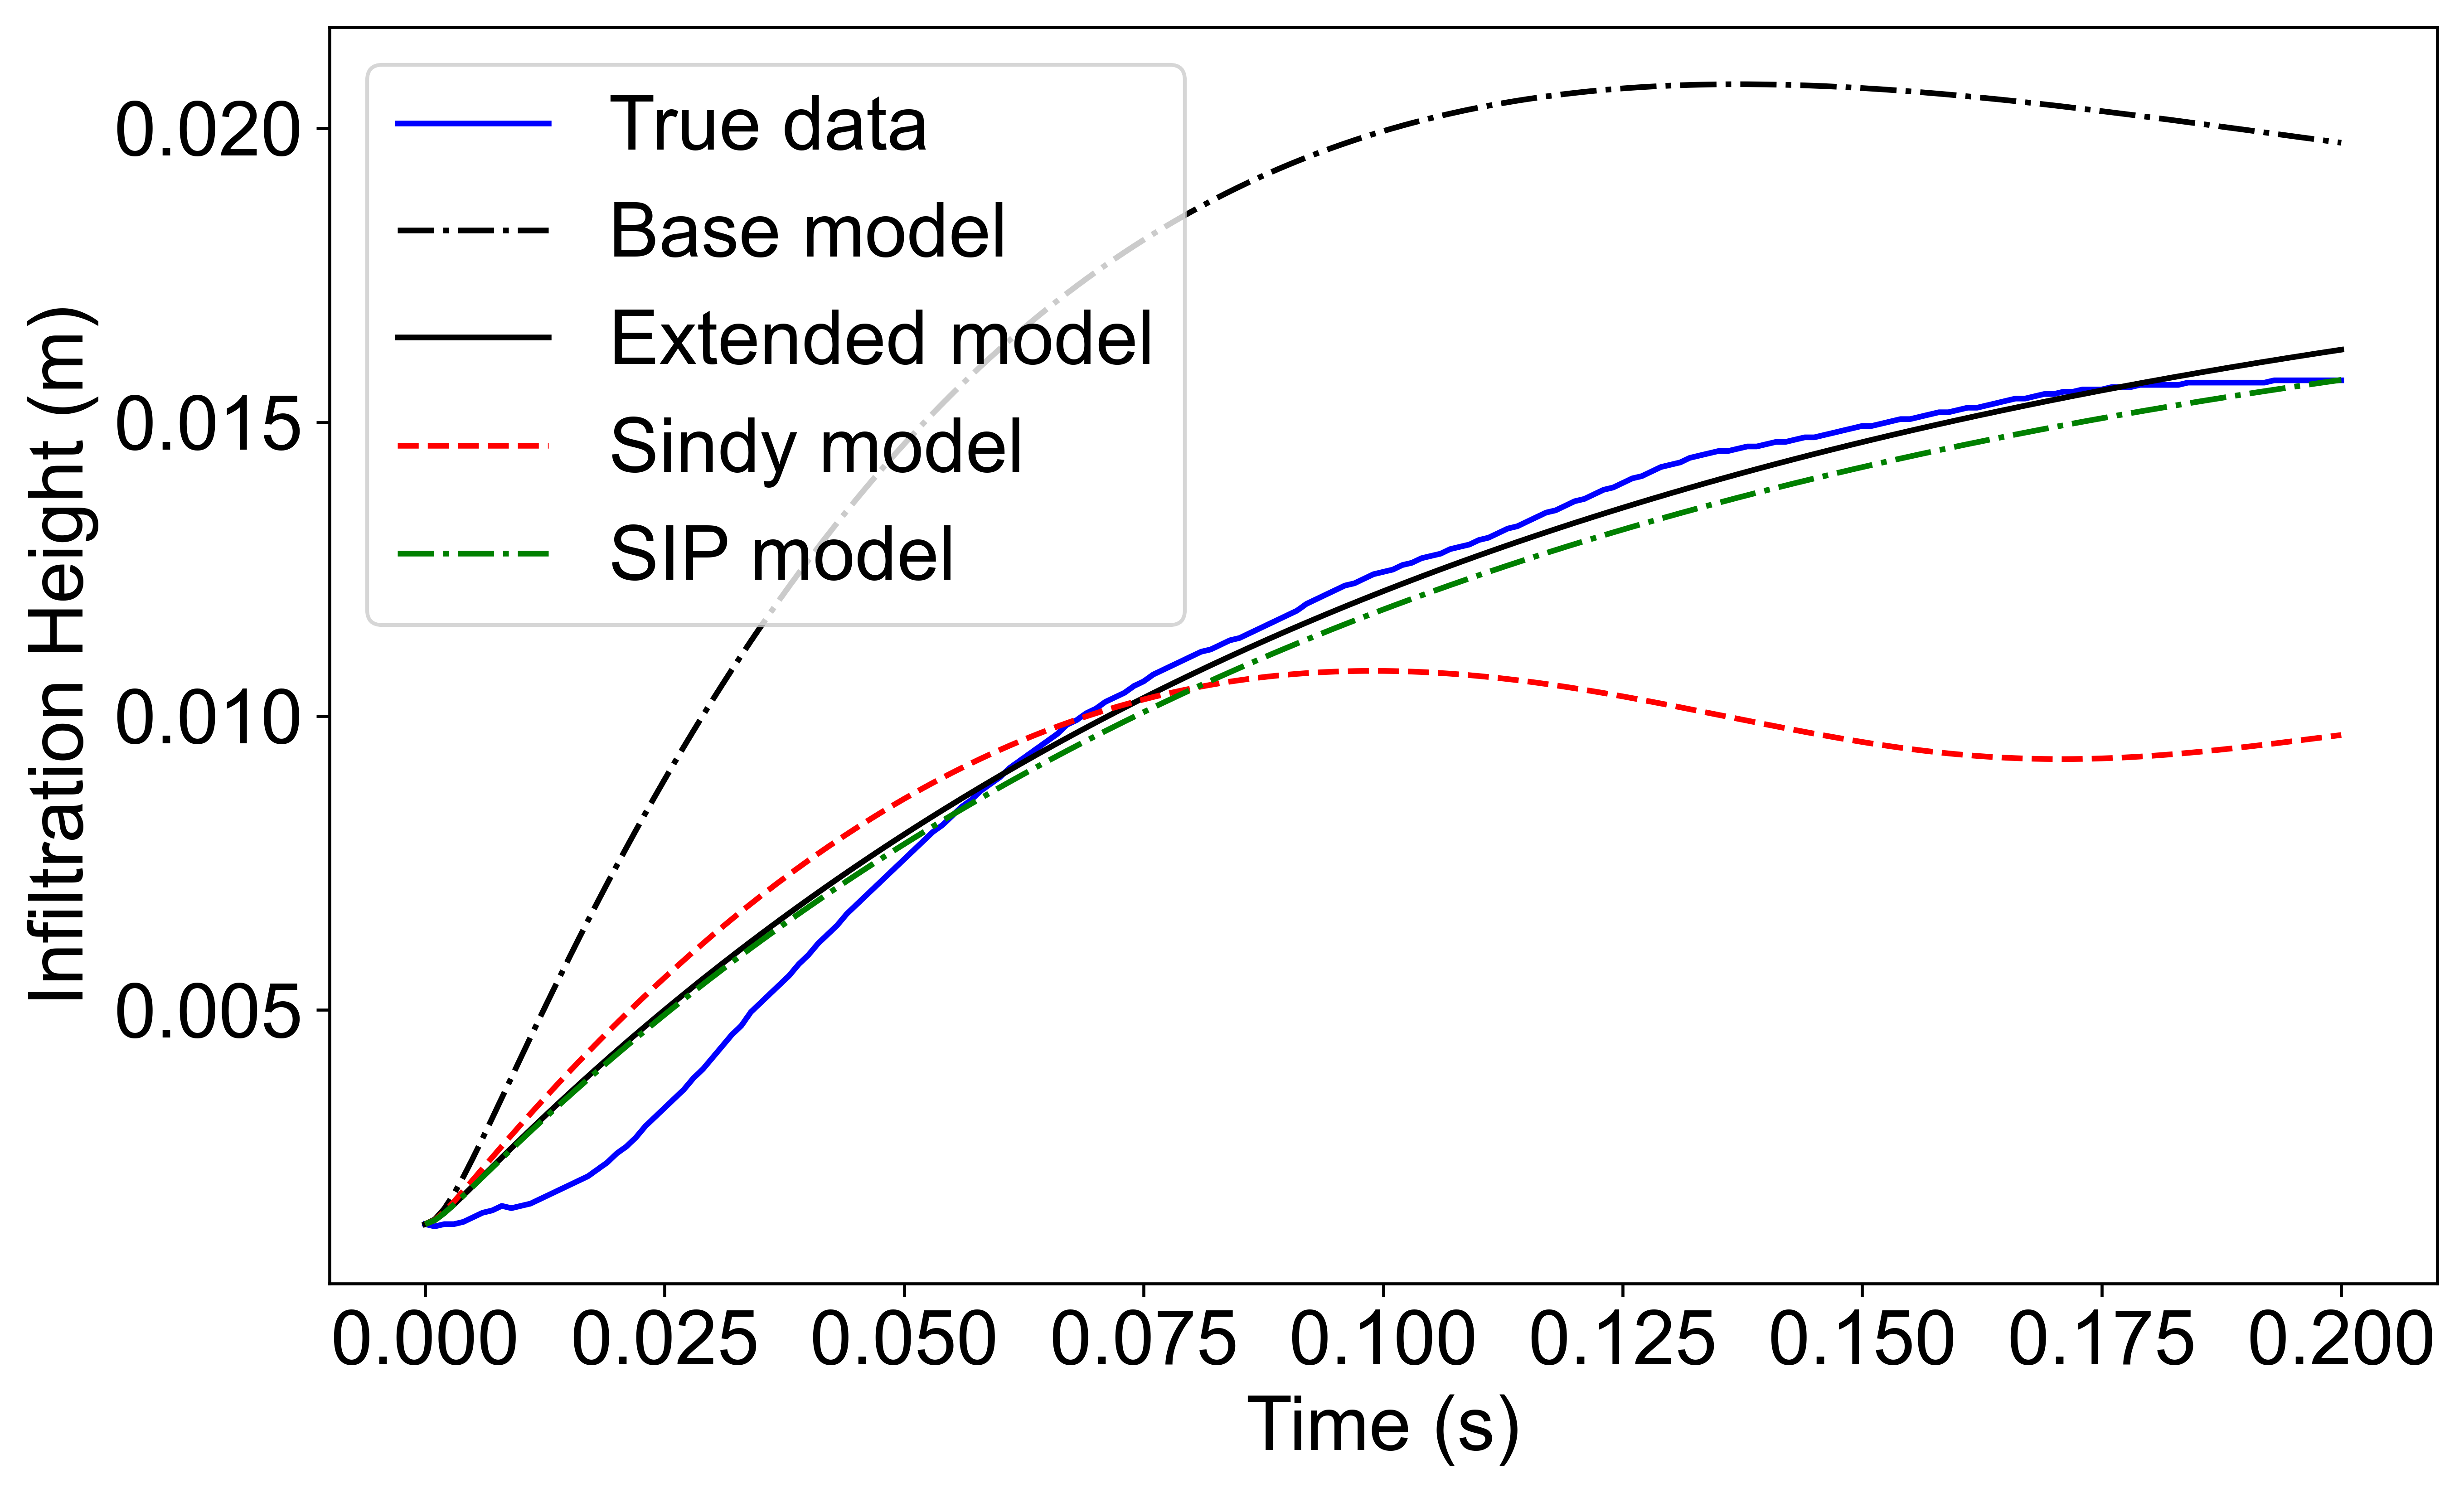

In [113]:
#Simulating Base model without including contact line friction effect
#Initial values and parameters of the digitized data
initial_vals_dgt = np.array([d_height[0], dl_dgt[0]])
digit_params = [density, viscosity, permeability, gravity, capillary_pressure]
simulated_digit = simulate_true_model(digit_params, initial_vals_dgt, d_time)
simulated_L = simulated_digit[0]
simulated_dL = simulated_digit[1]
#print parameter values
print(f"initial values = {initial_vals_dgt}")
print(f"Base Mean Squared Error = {mean_squared_error(d_height, simulated_L, squared = False)}")

# #Simulating extended model with contact line friction effect
# #Initial values and parameters of the digitized data
# true_friction_coefficient = 78.37
# initial_vals_dgt = np.array([d_height[0], dl_dgt[0]])
# ext_digit_params = [density, viscosity, permeability, gravity, capillary_pressure, true_friction_coefficient]
# ext_simulated_digit = simulate_extended_model(ext_digit_params, initial_vals_dgt, d_time)
# ext_simulated_L = ext_simulated_digit[0]
# ext_simulated_dL = ext_simulated_digit[1]
# #print parameter values
# # print(f"extended initial values = {initial_vals_dgt}")
# print(f"Extended Mean Squared Error = {mean_squared_error(d_height, ext_simulated_L, squared = False)}")

#Best \xi
best_friction_coefficient = 803.44
best_ext_digit_params = [density, viscosity, permeability, gravity, capillary_pressure, best_friction_coefficient]
bst_simu_L = ext_simulated_digit = simulate_extended_model(best_ext_digit_params, initial_vals_dgt, d_time)[0]
print(f"Extended Mean Squared Error = {mean_squared_error(d_height, bst_simu_L, squared = False)}")

#SINDY model
sindy_params = [1.62e4, 1.60e4, 3.85e3, 1.09e3, 10.62,2.45e5]
sindy_L = simulate_recovered_extended_model(sindy_params, initial_vals_dgt, d_time, Pc = capillary_pressure)[0]
print(f"Sindy Mean Squared Error = {mean_squared_error(d_height, sindy_L, squared = False)}")

#SIP model 9788.1237, 23544.97354497354, 997.77
SIP_params = [10.188e3, 23.8e3, 1.01e3, 980.25,823.44, 0.6]
SIP_L = simulate_recovered_extended_model(SIP_params, initial_vals_dgt, d_time, Pc = capillary_pressure)[0]
print(f"SIP Mean Squared Error = {mean_squared_error(d_height, SIP_L, squared = False)}")

#plot data
plt_figures()
plt.plot(d_time,d_height,'b', label = "True data")
plt.plot(d_time, simulated_L, 'k-.', label = "Base model")
plt.plot(d_time, bst_simu_L, 'k', label = "Extended model")
plt.plot(d_time, sindy_L, 'r--', label = "Sindy model")
plt.plot(d_time, SIP_L, 'g-.', label = "SIP model")


plt.legend()
# plt.title('Simulation at original viscosity = (0.3 mPa.s)')
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (m)')
plt.show()

In [114]:
np.sqrt(803.44)

28.345017198795276

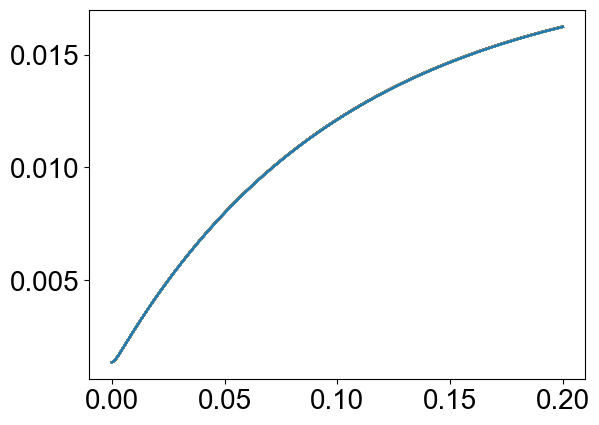

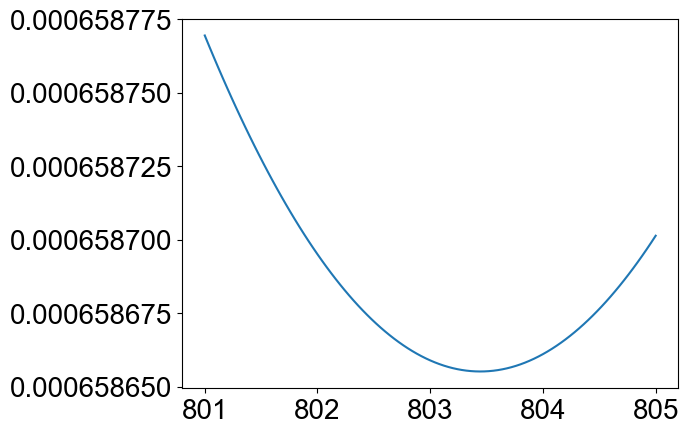

In [92]:
coefficients = np.linspace(801,805,101)
MSEs = []
for best_friction_coefficient in coefficients:
    best_ext_digit_params = [density, viscosity, permeability, gravity, capillary_pressure, best_friction_coefficient]
    bst_simu_L = ext_simulated_digit = simulate_extended_model(best_ext_digit_params, initial_vals_dgt, d_time)[0]
    MSEs.append(mean_squared_error(d_height, bst_simu_L, squared = False))
    plt.plot(d_time,bst_simu_L)
plt.show()   
plt.plot(coefficients,MSEs)
plt.show()

In [93]:
coefficients[np.argmin(MSEs)]

803.44

### KL Divergence between the data distribution and the pushforward of the posterior 

In [ ]:
from scipy.special import kl_div
post_dist = posterior_kde(X=Push_forward_of_Prior)
data_dist = kde_obs(X=Push_forward_of_Prior)
# data_dist,post_dist
kl_divergence = kl_div(data_dist,post_dist).sum()
kl_divergence